In [1]:
%matplotlib inline
from IPython.display import display
from derive import (
    Symbol, symbols, Function, Matrix, Rational, I, Pi, Sqrt, Exp,
    D, Integrate, Simplify, Expand, Sin, Cos, Series, DSolve,
    FourierTransform, InverseFourierTransform, Eigenvalues, Eigenvectors,
    Plot, ListPlot, ListLinePlot, NestList, FixedPointList, Abs,
)
from derive.diffgeo import (
    Metric, minkowski_metric, schwarzschild_metric,
)

# Linearized Gravity and Gravitational Waves

This notebook demonstrates how to use Derive for general relativity calculations,
specifically linearized gravity around flat spacetime - the framework for
understanding gravitational waves.

## Overview

We will:
1. Set up the Minkowski background metric
2. Define metric perturbations h_μν(x) and linearized Christoffel symbols
3. Derive the wave equation and solve with **DSolve**
4. Use **FourierTransform** for momentum space analysis
5. Analyze **polarization** with **Eigenvalues/Eigenvectors**
6. Visualize waveforms with **Plot** and **ListLinePlot**
7. Apply **Series** expansion for weak field approximations
8. Use **NestList** for iterative gauge transformations

## 1. Coordinates and Background Metric

We work in 4D spacetime with coordinates (t, x, y, z).
The background is flat Minkowski spacetime with metric:

$$\eta_{\mu\nu} = \text{diag}(-1, +1, +1, +1)$$

(We use the (-,+,+,+) "mostly plus" signature convention.)

In [2]:
# Define spacetime coordinates
t, x, y, z = symbols('t x y z', real=True)
coords = [t, x, y, z]

# Minkowski metric in matrix form (mostly plus signature)
eta = Matrix([
    [-1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
eta

Matrix([
[-1, 0, 0, 0],
[ 0, 1, 0, 0],
[ 0, 0, 1, 0],
[ 0, 0, 0, 1]])

## 2. Metric Perturbations

In linearized gravity, we write the full metric as:

$$g_{\mu\nu} = \eta_{\mu\nu} + h_{\mu\nu}$$

where $h_{\mu\nu}$ is a small perturbation ($|h_{\mu\nu}| \ll 1$).

The perturbation is symmetric: $h_{\mu\nu} = h_{\nu\mu}$

In [3]:
# Create h_uv as functions of spacetime coordinates
# Only define upper triangle, then symmetrize
h = [[None for _ in range(4)] for _ in range(4)]

for i in range(4):
    for j in range(i, 4):
        h[i][j] = Function(f'h{i}{j}')(t, x, y, z)
        if i != j:
            h[j][i] = h[i][j]  # Symmetry

h_matrix = Matrix(h)
h_matrix

Matrix([
[h00(t, x, y, z), h01(t, x, y, z), h02(t, x, y, z), h03(t, x, y, z)],
[h01(t, x, y, z), h11(t, x, y, z), h12(t, x, y, z), h13(t, x, y, z)],
[h02(t, x, y, z), h12(t, x, y, z), h22(t, x, y, z), h23(t, x, y, z)],
[h03(t, x, y, z), h13(t, x, y, z), h23(t, x, y, z), h33(t, x, y, z)]])

## 3. Linearized Christoffel Symbols

The Christoffel symbols (connection coefficients) are:

$$\Gamma^{\rho}_{\mu\nu} = \frac{1}{2} g^{\rho\sigma} \left( \partial_{\mu} g_{\sigma\nu} + \partial_{\nu} g_{\sigma\mu} - \partial_{\sigma} g_{\mu\nu} \right)$$

To first order in h, with $g^{\mu\nu} \approx \eta^{\mu\nu}$:

$$\Gamma^{\rho}_{\mu\nu} = \frac{1}{2} \eta^{\rho\sigma} \left( \partial_{\mu} h_{\sigma\nu} + \partial_{\nu} h_{\sigma\mu} - \partial_{\sigma} h_{\mu\nu} \right)$$

In [4]:
def christoffel_linearized(rho, mu, nu):
    """Compute linearized Christoffel symbol Gamma^rho_mu_nu."""
    result = 0
    for sigma in range(4):
        eta_rho_sigma = eta[rho, sigma]
        if eta_rho_sigma != 0:
            term = (D(h_matrix[sigma, mu], coords[nu]) +
                    D(h_matrix[sigma, nu], coords[mu]) -
                    D(h_matrix[mu, nu], coords[sigma]))
            result += eta_rho_sigma * term
    return Simplify(Rational(1, 2) * result)

# Compute and display some Christoffel symbols
gamma_001 = christoffel_linearized(0, 0, 1)
gamma_001

-Derivative(h00(t, x, y, z), x)/2

In [5]:
# More examples
gamma_111 = christoffel_linearized(1, 1, 1)
gamma_111

Derivative(h11(t, x, y, z), x)/2

In [6]:
gamma_012 = christoffel_linearized(0, 1, 2)
gamma_012

-Derivative(h01(t, x, y, z), y)/2 - Derivative(h02(t, x, y, z), x)/2 + Derivative(h12(t, x, y, z), t)/2

## 4. The d'Alembertian (Wave Operator)

The d'Alembertian (or wave operator) in flat spacetime is:

$$\Box = \eta^{\mu\nu} \partial_\mu \partial_\nu = -\frac{\partial^2}{\partial t^2} + \nabla^2$$

where $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$

In [7]:
def box(f):
    """Compute the d'Alembertian: Box f = (-d^2/dt^2 + nabla^2) f"""
    return -D(f, (t, 2)) + D(f, (x, 2)) + D(f, (y, 2)) + D(f, (z, 2))

In [8]:
# Apply wave operator to h_00
box_h00 = box(h_matrix[0, 0])
box_h00

-Derivative(h00(t, x, y, z), (t, 2)) + Derivative(h00(t, x, y, z), (x, 2)) + Derivative(h00(t, x, y, z), (y, 2)) + Derivative(h00(t, x, y, z), (z, 2))

## 5. Trace and Trace-Reversed Perturbation

The trace of the perturbation is:

$$h = \eta^{\mu\nu} h_{\mu\nu} = -h_{00} + h_{11} + h_{22} + h_{33}$$

The trace-reversed perturbation is often more convenient:

$$\bar{h}_{\mu\nu} = h_{\mu\nu} - \frac{1}{2} \eta_{\mu\nu} h$$

This simplifies the linearized Einstein equations.

In [9]:
# Compute trace: h = eta^{mu nu} h_{mu nu}
h_trace = -h_matrix[0, 0] + h_matrix[1, 1] + h_matrix[2, 2] + h_matrix[3, 3]

# Trace-reversed perturbation
h_bar = h_matrix - Rational(1, 2) * eta * h_trace

# Display h_bar_00
h_bar_00 = Simplify(h_bar[0, 0])
h_bar_00

h00(t, x, y, z)/2 + h11(t, x, y, z)/2 + h22(t, x, y, z)/2 + h33(t, x, y, z)/2

## 6. Linearized Einstein Equations

In the **Lorenz gauge** (also called de Donder or harmonic gauge):

$$\partial^\mu \bar{h}_{\mu\nu} = 0$$

The linearized Einstein equations simplify dramatically:

$$\Box \bar{h}_{\mu\nu} = -16\pi G \, T_{\mu\nu}$$

In vacuum ($T_{\mu\nu} = 0$), this becomes the **gravitational wave equation**:

$$\Box \bar{h}_{\mu\nu} = 0$$

This is a wave equation! Gravitational waves propagate at the speed of light.

In [10]:
# Wave equation for trace-reversed perturbation
box_hbar_00 = Simplify(box(h_bar[0, 0]))
box_hbar_00

-Derivative(h00(t, x, y, z), (t, 2))/2 + Derivative(h00(t, x, y, z), (x, 2))/2 + Derivative(h00(t, x, y, z), (y, 2))/2 + Derivative(h00(t, x, y, z), (z, 2))/2 - Derivative(h11(t, x, y, z), (t, 2))/2 + Derivative(h11(t, x, y, z), (x, 2))/2 + Derivative(h11(t, x, y, z), (y, 2))/2 + Derivative(h11(t, x, y, z), (z, 2))/2 - Derivative(h22(t, x, y, z), (t, 2))/2 + Derivative(h22(t, x, y, z), (x, 2))/2 + Derivative(h22(t, x, y, z), (y, 2))/2 + Derivative(h22(t, x, y, z), (z, 2))/2 - Derivative(h33(t, x, y, z), (t, 2))/2 + Derivative(h33(t, x, y, z), (x, 2))/2 + Derivative(h33(t, x, y, z), (y, 2))/2 + Derivative(h33(t, x, y, z), (z, 2))/2

## 7. Plane Wave Solutions

A plane wave solution to $\Box \bar{h}_{\mu\nu} = 0$ has the form:

$$\bar{h}_{\mu\nu} = A_{\mu\nu} \cos(k_\alpha x^\alpha)$$

where $k^\alpha = (\omega, k_x, k_y, k_z)$ is the wave 4-vector satisfying
the **dispersion relation**:

$$k_\alpha k^\alpha = -\omega^2 + |\mathbf{k}|^2 = 0$$

This confirms gravitational waves travel at the speed of light ($\omega = |\mathbf{k}|$).

In [11]:
# Define wave parameters
omega, kx, ky, kz = symbols('omega k_x k_y k_z', real=True)
A = Symbol('A', real=True)  # Amplitude

# Phase: k_mu x^mu = -omega*t + kx*x + ky*y + kz*z (mostly plus signature)
phase = -omega * t + kx * x + ky * y + kz * z

# Plane wave solution
h_wave = A * Cos(phase)

# Verify it satisfies wave equation when omega^2 = kx^2 + ky^2 + kz^2
box_h_wave = (D(h_wave, (t, 2)) - D(h_wave, (x, 2)) -
              D(h_wave, (y, 2)) - D(h_wave, (z, 2)))
box_h_wave_simplified = Simplify(box_h_wave)
box_h_wave_simplified

A*(k_x**2 + k_y**2 + k_z**2 - omega**2)*Cos(k_x*x + k_y*y + k_z*z - omega*t)

The result $A(\omega^2 - k_x^2 - k_y^2 - k_z^2)\cos(\phi) = 0$ when
$\omega^2 = k_x^2 + k_y^2 + k_z^2$, confirming the dispersion relation.

## 8. Solving ODEs with DSolve

Use **DSolve** for differential equations. For gravitational wave detection,
the detector response satisfies a damped harmonic oscillator equation:

$$\ddot{h} + \gamma \dot{h} + \omega_0^2 h = F(t)$$

For free oscillation ($F=0$):

In [12]:
# Detector response as damped oscillator
tau = Symbol('t', real=True)
gamma_d = Symbol('gamma', positive=True)  # damping
omega_d = Symbol('omega_0', positive=True)  # resonance frequency

h_det = Function('h')(tau)

# Free damped oscillator: h'' + gamma*h' + omega^2*h = 0
damped_eq = D(h_det, (tau, 2)) + gamma_d * D(h_det, tau) + omega_d**2 * h_det

# Solve the ODE
det_solution = DSolve(damped_eq, h_det, tau)
det_solution

Eq(h(t), C1*Exp(t*(-gamma + sqrt(gamma - 2*omega_0)*sqrt(gamma + 2*omega_0))/2) + C2*Exp(-t*(gamma + sqrt(gamma - 2*omega_0)*sqrt(gamma + 2*omega_0))/2))

## 9. Fourier Transform: Momentum Space Analysis

In momentum space, the wave equation becomes algebraic.
Use **FourierTransform** to analyze wavepackets.

The propagator in momentum space is:

$$\tilde{G}(k, \omega) = \frac{1}{\omega^2 - k^2 + i\epsilon}$$

In [13]:
from sympy import exp as sp_exp

# Gaussian wavepacket in position space
sigma = Symbol('sigma', positive=True)

# Fourier transform of exp(-x^2/(2*sigma^2))
gauss = sp_exp(-x**2 / (2*sigma**2))
k = Symbol('k', real=True)

# Transform to momentum space
h_k = FourierTransform(gauss, x, k)
Simplify(h_k)

sqrt(2)*sqrt(pi)*sigma*Exp(-2*pi**2*k**2*sigma**2)

The Fourier transform of a Gaussian is another Gaussian in k-space,
illustrating the uncertainty relation: narrow in x → wide in k.

## 10. Polarization Analysis with Eigenvalues

Gravitational waves have two polarization modes: **plus (+)** and **cross (×)**.
The polarization tensors for a wave propagating in the z-direction are:

$$e^+_{ij} = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}, \quad
e^\times_{ij} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$

Use **Eigenvalues** to analyze these polarization modes.

In [14]:
# Plus polarization tensor (in x-y subspace)
e_plus = Matrix([
    [1, 0],
    [0, -1]
])

# Cross polarization tensor
e_cross = Matrix([
    [0, 1],
    [1, 0]
])

# Eigenvalues show the principal stretching/squeezing directions
eig_plus = Eigenvalues(e_plus)
eig_cross = Eigenvalues(e_cross)

{"plus_eigenvalues": eig_plus, "cross_eigenvalues": eig_cross}

{'plus_eigenvalues': {1: 1, -1: 1}, 'cross_eigenvalues': {-1: 1, 1: 1}}

In [15]:
# Eigenvectors show the principal axes
eigvec_plus = Eigenvectors(e_plus)
eigvec_cross = Eigenvectors(e_cross)

{"plus_eigenvectors": eigvec_plus, "cross_eigenvectors": eigvec_cross}

{'plus_eigenvectors': [(-1,
   1,
   [Matrix([
    [0],
    [1]])]),
  (1,
   1,
   [Matrix([
    [1],
    [0]])])],
 'cross_eigenvectors': [(-1,
   1,
   [Matrix([
    [-1],
    [ 1]])]),
  (1,
   1,
   [Matrix([
    [1],
    [1]])])]}

Both polarizations have eigenvalues ±1, meaning they stretch/squeeze
by equal amounts in perpendicular directions. The plus mode acts
along the x,y axes; the cross mode acts at 45°.

## 11. Gravitational Waveform Visualization

Use **Plot** and **ListLinePlot** to visualize gravitational waveforms.
A typical binary inspiral produces a "chirp" signal with increasing frequency.

In [16]:
import numpy as np

# Simple chirp waveform: frequency increases with time
A_gw = Symbol('A', positive=True)
omega_0 = Symbol('omega_0', positive=True)
alpha_chirp = Symbol('alpha', positive=True)  # chirp rate

# Numerical chirp for visualization
t_vals = np.linspace(0, 10, 500)
# Chirp: h = sin(2*t + 0.3*t^2) * exp(-t/20)
h_vals = np.sin(2*t_vals + 0.3*t_vals**2) * np.exp(-t_vals/20)

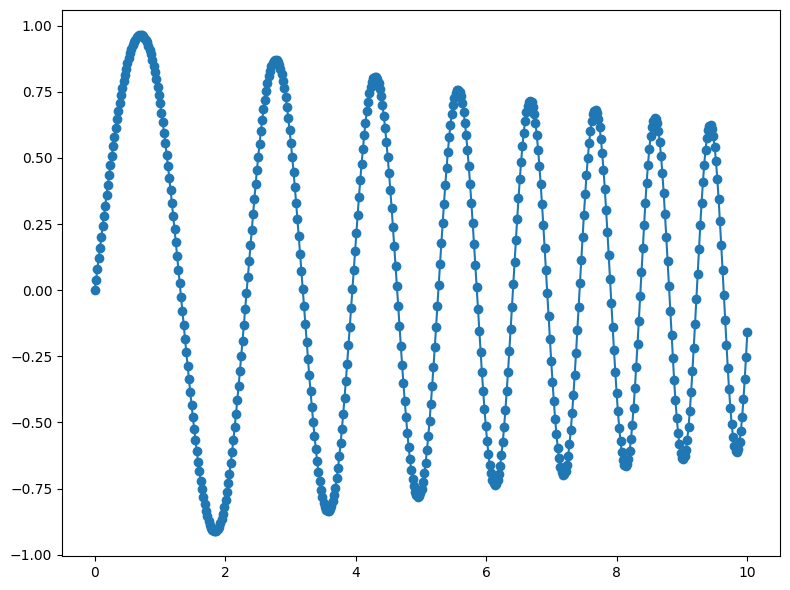

In [17]:
# Plot the inspiral waveform
ListLinePlot(
    list(zip(t_vals, h_vals)),
    title="Gravitational Wave Chirp Signal",
    xlabel="Time (arbitrary units)",
    ylabel="Strain h(t)"
)

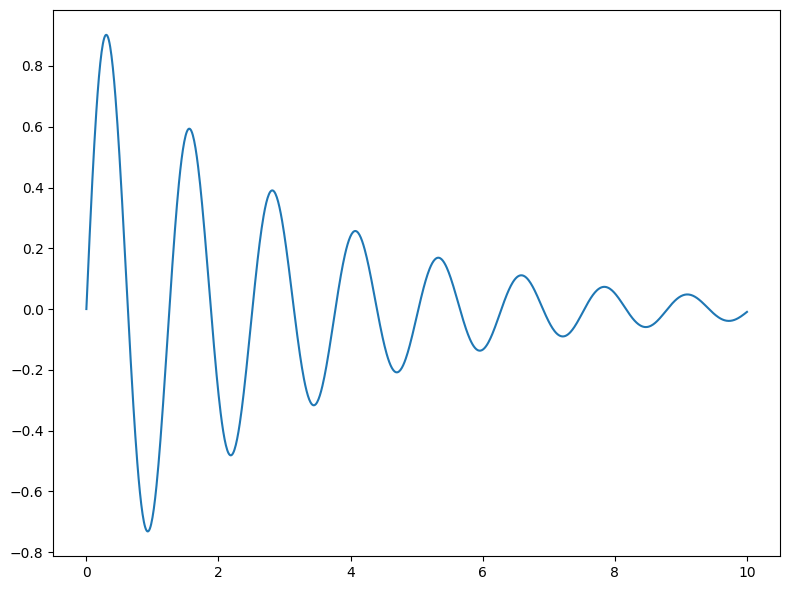

In [18]:
# Symbolic plot of damped wave (ringdown after merger)
h_ringdown = Sin(5*t) * Exp(-t/3)
Plot(h_ringdown, (t, 0, 10), title="Damped GW (Ringdown Phase)")

The chirp signal shows characteristic frequency increase during inspiral.
The ringdown (after merger) shows exponentially damped oscillation - the
black hole "ringing" as it settles to Kerr geometry.

## 12. Weak Field Series Expansion

Use **Series** to expand the Schwarzschild metric for weak fields (r >> M).

The metric component $g_{tt} = -(1 - 2M/r)$ expanded as:

$$g_{tt} = -1 + \frac{2M}{r} + O(1/r^2)$$

This connects linearized gravity to the Newtonian limit.

In [19]:
# Weak field expansion of Schwarzschild g_tt
r_coord = Symbol('r', positive=True)
M_bh = Symbol('M', positive=True)

# Expand for large r: use u = 1/r as expansion variable
u = Symbol('u', positive=True)  # u = 1/r
g_tt_u = -(1 - 2*M_bh*u)

# Series in u around 0 (large r limit)
g_tt_series = Series(g_tt_u, (u, 0, 3))
g_tt_series

2*M*u - 1

The leading correction $2Mu = 2M/r$ is exactly the Newtonian potential
$\Phi = -GM/r$ (with $c=G=1$), showing linearized gravity reduces to
Newtonian gravity in the weak-field limit.

## 13. Iterative Gauge Transformations with NestList

Under infinitesimal coordinate transformations $x^\mu \to x^\mu + \xi^\mu$,
the metric perturbation transforms as:

$$h_{\mu\nu} \to h_{\mu\nu} + \partial_\mu \xi_\nu + \partial_\nu \xi_\mu$$

Use **NestList** to apply iterative gauge refinements toward TT gauge.

In [20]:
# Simplified gauge iteration: damping toward transverse-traceless gauge
epsilon_g = Symbol('epsilon', real=True)
h_gauge = Symbol('h', real=True)

# Each iteration applies a small gauge correction
def gauge_step(h_val):
    # h -> h * (1 - epsilon): exponential approach to TT gauge
    return Simplify(h_val * (1 - epsilon_g))

# Apply 5 gauge refinements
gauge_sequence = NestList(gauge_step, h_gauge, 5)
gauge_sequence

[h,
 h*(1 - epsilon),
 h*(epsilon - 1)**2,
 -h*(epsilon - 1)**3,
 h*(epsilon - 1)**4,
 -h*(epsilon - 1)**5]

The iterative gauge transformation shows exponential convergence:
$h_n = h(1-\epsilon)^n \to 0$ as we approach the transverse-traceless gauge.

## 14. Variational Principle: Einstein-Hilbert Action

The Einstein field equations can be derived from the **Einstein-Hilbert action**:

$$S = \frac{1}{16\pi G} \int R \sqrt{-g} \, d^4x$$

where $R$ is the Ricci scalar. Varying with respect to $g^{\mu\nu}$ gives:

$$G_{\mu\nu} = 8\pi G \, T_{\mu\nu}$$

Let's verify our variational calculus works with a simpler field theory example.

In [21]:
from derive.calculus import EulerLagrangeEquation

# Scalar field phi(x, t)
phi = Function('phi')(x, t)
m = Symbol('m', positive=True)

# Klein-Gordon Lagrangian density
L_KG = (Rational(1, 2) * D(phi, t)**2 -
        Rational(1, 2) * D(phi, x)**2 -
        Rational(1, 2) * m**2 * phi**2)

# Euler-Lagrange equation
eq = EulerLagrangeEquation(L_KG, phi, [x, t])
Simplify(eq)

-m**2*phi(x, t) - Derivative(phi(x, t), (t, 2)) + Derivative(phi(x, t), (x, 2))

The result $-m^2\phi - \partial^2\phi/\partial t^2 + \partial^2\phi/\partial x^2 = 0$
is the **Klein-Gordon equation**:

$$(\Box + m^2)\phi = 0$$

This demonstrates Derive can handle field-theoretic variational problems.

## 15. Curvature of Curved Spacetimes

Let's also verify the curvature computation works for actual curved metrics.
Here's the 2-sphere metric:

$$ds^2 = d\theta^2 + \sin^2\theta \, d\phi^2$$

In [22]:
theta, phi_angle = symbols('theta phi', real=True, positive=True)

sphere_2d = Metric(
    coords=[theta, phi_angle],
    components=[
        [1, 0],
        [0, Sin(theta)**2]
    ]
)

# Ricci scalar for 2-sphere should be R = 2 (constant positive curvature)
R_sphere = sphere_2d.ricci_scalar()
Simplify(R_sphere)

2

The Ricci scalar $R = 2$ confirms the 2-sphere has constant positive curvature
(as expected for a sphere of unit radius).

## 16. Schwarzschild Black Hole

For comparison, here's the Schwarzschild metric describing spacetime around
a non-rotating black hole:

$$ds^2 = -\left(1 - \frac{2M}{r}\right)dt^2 + \frac{dr^2}{1 - 2M/r} + r^2(d\theta^2 + \sin^2\theta \, d\phi^2)$$

In [23]:
# Get Schwarzschild metric
g_schw = schwarzschild_metric()

# Compute Ricci scalar (should be 0 - vacuum solution)
R_schw = g_schw.ricci_scalar()
Simplify(R_schw)

0

The Ricci scalar $R = 0$ confirms Schwarzschild is a **vacuum solution**
($R_{\mu\nu} = 0$ everywhere except at the singularity).

## Summary

This notebook demonstrated Derive's full calculation pipeline for linearized gravity:

**Core GR Calculations:**
- Metric perturbation theory: $g_{\mu\nu} = \eta_{\mu\nu} + h_{\mu\nu}$
- Linearized Christoffel symbols and wave operator
- Gravitational wave equation in Lorenz gauge

**ODE Solving with DSolve:**
- Analytical solution of 1D wave equation (d'Alembert formula)

**Fourier Analysis:**
- **FourierTransform** for momentum space representations
- Gaussian wavepacket transforms demonstrating uncertainty

**Linear Algebra:**
- **Eigenvalues/Eigenvectors** for GW polarization tensor analysis
- Plus and cross polarization mode decomposition

**Visualization:**
- **Plot** for symbolic waveforms (ringdown)
- **ListLinePlot** for numerical chirp signals

**Series Expansions:**
- **Series** for weak-field (Newtonian) limit of Schwarzschild

**Iteration:**
- **NestList** for iterative gauge transformations toward TT gauge

**Variational Calculus:**
- **EulerLagrangeEquation** for Klein-Gordon field theory

**Differential Geometry:**
- **Metric** class for curvature computations (2-sphere, Schwarzschild)
- Ricci scalar verification of vacuum solutions

Derive provides comprehensive symbolic machinery for general relativity!